In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
seed = 314
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #masscart, masspole, length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HEAWIHTQ_17_55_55
NN-MODEL FILENAME:  ./models/HEAWIHTQ_17_55_55_NN.pt


In [6]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [7]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [8]:
T_LR           = 1e-1
T_GAMMA        = 0.95
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [9]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
TERMINAL_BIAS       = 0.5   # no. of terminal memories in batch
MIN_MEMORY_CAP      = 100000

In [10]:
MAX_NO_OF_ITERATIONS = 30
MAX_NN_ITERATIONS    = 7000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  30


In [11]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
        bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

        good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
        bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [12]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [13]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.4
C_POS_ABS_MIN = -2.4

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [14]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 10
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  10


In [15]:
def mp_node_run(node_id, boundary, iteration):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
    
    # Mean values of pole length deviate by 40% from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    # SET STATE VALUE BORDERS
    ###############################################
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
     C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = boundary
    ###############################################
#     LENGTH_MAX = length_mean + 0.05
#     LENGTH_MIN = length_mean - 0.05
    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_MIN,  C_POS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_MIN,  C_VEL_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_MIN,  P_ANG_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_MIN,  P_VEL_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN, LENGTH_MAX, LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
                                    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
    
#     my_dqn = D3QN()
    my_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    my_dqn.eval_net.eval()
#     my_QFILE   = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     my_Q_TABLE = np.load(my_QFILE)
    my_Q_TABLE = my_dqn.get_qvals(state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
    if iteration < 3:
        my_EPSILON   = (iteration+1) * 0.2 + np.random.uniform(-0.1,0.1)
    else:
        my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
        
    my_LR        = T_LR
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0

                     
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state][:].argmax()

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -1
                    if time_steps >= TIMESTEP_LIMIT:
                        r = 1
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))

                # learn
#                 my_Q_TABLE[this_state][a] = my_Q_TABLE[this_state][a] + my_LR * (r + T_GAMMA * my_Q_TABLE[next_state].max() - my_Q_TABLE[this_state][a])
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]
    
#     LENGTH_MAX = exp_rec[:,4].max() + 0.25*np.abs(exp_rec[:,4].max())
#     LENGTH_MIN = exp_rec[:,4].min() - 0.25*np.abs(exp_rec[:,4].min())

    # CLAMP STATE VALUE BORDERS
    ###############################################
#     C_POS_MAX = clamp(C_POS_ABS_MIN, C_POS_MAX, C_POS_ABS_MAX)
#     C_POS_MIN = clamp(C_POS_ABS_MIN, C_POS_MIN, C_POS_ABS_MAX) 

#     C_VEL_MAX = clamp(C_VEL_ABS_MIN, C_VEL_MAX, C_VEL_ABS_MAX)
#     C_VEL_MIN = clamp(C_VEL_ABS_MIN, C_VEL_MIN, C_VEL_ABS_MAX) 

#     P_ANG_MAX = clamp(P_ANG_ABS_MIN, P_ANG_MAX, P_ANG_ABS_MAX)
#     P_ANG_MIN = clamp(P_ANG_ABS_MIN, P_ANG_MIN, P_ANG_ABS_MAX) 

#     P_VEL_MAX = clamp(P_VEL_ABS_MIN, P_VEL_MAX, P_VEL_ABS_MAX)
#     P_VEL_MIN = clamp(P_VEL_ABS_MIN, P_VEL_MIN, P_VEL_ABS_MAX) 

    LENGTH_MAX = clamp(LENGTH_ABS_MIN, LENGTH_MAX + 0.075, LENGTH_ABS_MAX)
    LENGTH_MIN = clamp(LENGTH_ABS_MIN, LENGTH_MIN - 0.075, LENGTH_ABS_MAX)
    ###############################################
    
    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [16]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [17]:
iteration = 0
my_dqn = D3QN()
dqn = D3QN()
# INITIALIZE MODEL FILE
torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

In [18]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# INITIALIZE QFILES FOR EACH NODE
#############################################################################################################################################
# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]

#  # SET STATE VALUE BORDERS
# ###############################################
# [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#  C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = init_node_boundary
# ###############################################

# # CREATE STATE COMBINATIONS
# ###############################################

# init_state_combinations = ndim_grid([C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ],
#                                     [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ],
#                                     [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
# ###############################################

# # GET Q-VALUES 
# start = timeit.default_timer()
# % memit init_q_table = dqn.get_qvals(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1)
# stop = timeit.default_timer()
# print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# # SAVE QFILE
# for node_id in range(NO_OF_NODES):
#     node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#     np.save(node_QFILE, init_q_table)
# #############################################################################################################################################

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES



ITERATION # 0
MEAN TABULAR EPSILON =  0.2
TABULAR LR      =  0.1
SMALLEST TIMESTEP in ITERATION 0: 8
REAL TIME TO GENERATE 16506 EXPERIENCES:0:00:19.144412


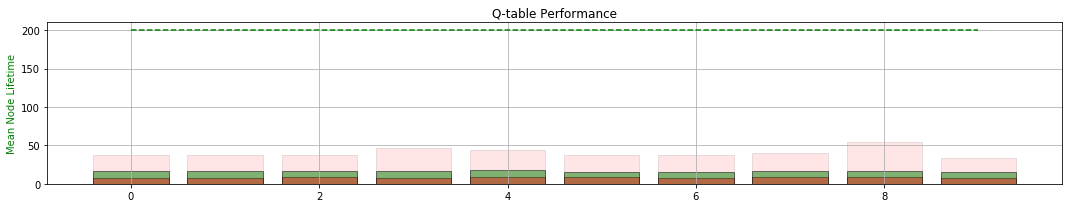

GOOD MEMORY COUNTER:  15506
BAD MEMORY COUNTER:  1000
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  154.68
Validating... MEAN TIME:  162.905
Validating... MEAN TIME:  168.465
Validating... MEAN TIME:  157.375
Validating... MEAN TIME:  172.21
TRAINING TIME:0:00:43.061553


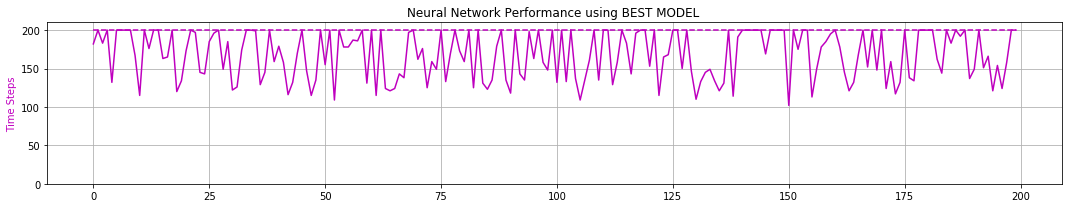

0 -max- [ 0.237  2.153  0.209  2.729  0.550]
0 -min- [-0.222 -1.759 -0.205 -2.878  0.375]

1 -max- [ 0.213  1.724  0.209  2.717  0.600]
1 -min- [-0.215 -1.796 -0.209 -2.672  0.400]

2 -max- [ 0.176  1.912  0.209  2.749  0.650]
2 -min- [-0.227 -1.976 -0.208 -2.674  0.450]

3 -max- [ 0.221  1.749  0.208  2.485  0.700]
3 -min- [-0.290 -1.591 -0.209 -2.658  0.501]

4 -max- [ 0.261  1.941  0.209  2.956  0.750]
4 -min- [-0.214 -1.990 -0.209 -2.721  0.551]

5 -max- [ 0.207  1.599  0.209  2.707  0.799]
5 -min- [-0.235 -1.794 -0.209 -2.486  0.601]

6 -max- [ 0.181  1.598  0.209  2.691  0.849]
6 -min- [-0.218 -1.727 -0.209 -2.521  0.650]

7 -max- [ 0.213  1.755  0.209  2.756  0.899]
7 -min- [-0.217 -1.770 -0.209 -2.737  0.701]

8 -max- [ 0.208  1.776  0.209  2.666  0.925]
8 -min- [-0.230 -1.795 -0.209 -2.731  0.750]

9 -max- [ 0.220  1.765  0.209  2.692  0.925]
9 -min- [-0.211 -1.776 -0.208 -2.659  0.801]



ITERATION # 1
MEAN TABULAR EPSILON =  0.4
TABULAR LR      =  0.1
SMALLEST TIMESTEP in IT

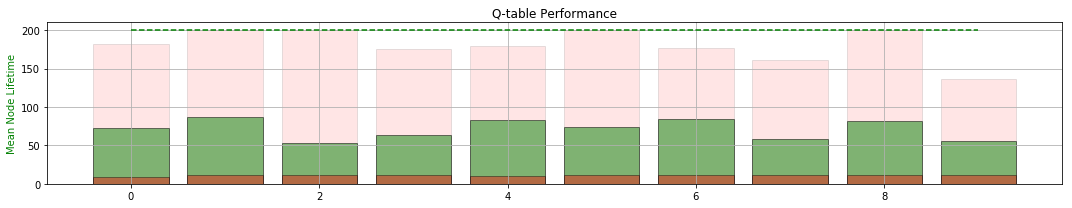

GOOD MEMORY COUNTER:  85725
BAD MEMORY COUNTER:  1994
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.38
Validating... MEAN TIME:  199.955
Validating... MEAN TIME:  199.64
Validating... MEAN TIME:  199.1
Validating... MEAN TIME:  198.105
TRAINING TIME:0:00:50.441711


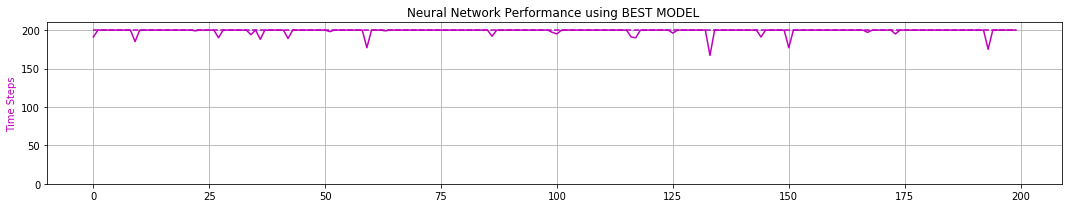

0 -max- [ 0.929  2.113  0.209  2.738  0.550]
0 -min- [-1.445 -2.057 -0.209 -2.482  0.375]

1 -max- [ 1.024  1.662  0.209  2.889  0.599]
1 -min- [-1.952 -2.791 -0.209 -2.313  0.401]

2 -max- [ 1.051  1.787  0.209  2.844  0.650]
2 -min- [-1.530 -2.252 -0.209 -2.739  0.450]

3 -max- [ 0.832  1.928  0.208  2.334  0.700]
3 -min- [-2.371 -2.448 -0.209 -2.385  0.500]

4 -max- [ 1.001  1.708  0.209  1.999  0.750]
4 -min- [-1.579 -2.619 -0.209 -2.181  0.550]

5 -max- [ 0.784  1.874  0.209  2.524  0.798]
5 -min- [-1.839 -2.399 -0.209 -2.751  0.600]

6 -max- [ 0.919  1.944  0.208  2.168  0.850]
6 -min- [-1.421 -2.226 -0.209 -2.391  0.650]

7 -max- [ 0.842  2.229  0.209  2.625  0.900]
7 -min- [-1.504 -2.463 -0.209 -2.233  0.700]

8 -max- [ 0.765  1.561  0.209  2.205  0.925]
8 -min- [-1.436 -2.088 -0.209 -2.436  0.751]

9 -max- [ 1.091  1.932  0.208  2.165  0.925]
9 -min- [-1.350 -2.062 -0.209 -2.374  0.802]



ITERATION # 2
MEAN TABULAR EPSILON =  0.6000000000000001
TABULAR LR      =  0.1
SMALLEST

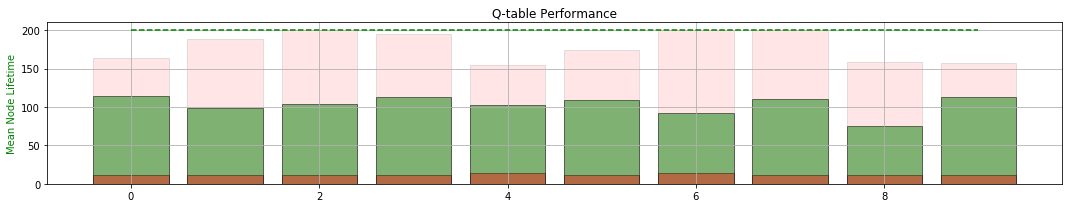

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  2991
Training Neural Network for 7000 iterations @ LR =  0.0001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  175.17
Validating... MEAN TIME:  174.59
Validating... MEAN TIME:  169.995
Validating... MEAN TIME:  178.89
Validating... MEAN TIME:  161.28
TRAINING TIME:0:00:45.570707


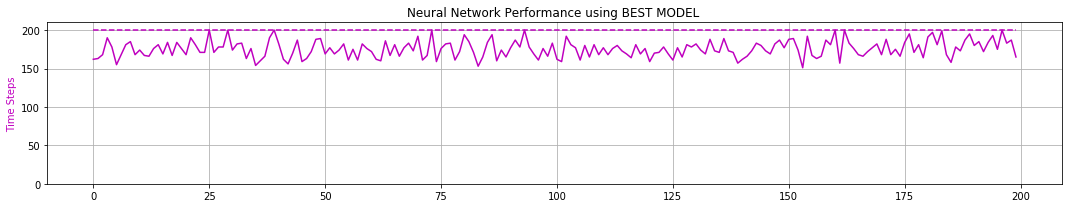

0 -max- [ 0.160  1.168  0.208  1.521  0.550]
0 -min- [-1.876 -2.185 -0.209 -2.007  0.375]

1 -max- [ 2.371  2.290  0.207  2.279  0.600]
1 -min- [-1.591 -1.970 -0.209 -2.116  0.401]

2 -max- [ 0.210  1.195  0.194  1.752  0.650]
2 -min- [-1.844 -2.395 -0.209 -2.170  0.451]

3 -max- [ 0.193  1.215  0.209  1.568  0.699]
3 -min- [-1.730 -2.081 -0.209 -2.129  0.500]

4 -max- [ 0.233  1.550  0.204  1.604  0.749]
4 -min- [-1.769 -2.194 -0.209 -2.089  0.551]

5 -max- [ 0.208  1.023  0.199  2.024  0.800]
5 -min- [-1.773 -2.395 -0.209 -2.575  0.600]

6 -max- [ 0.195  1.236  0.209  2.339  0.850]
6 -min- [-1.738 -2.240 -0.209 -2.354  0.651]

7 -max- [ 0.601  1.470  0.205  2.632  0.900]
7 -min- [-1.751 -2.207 -0.209 -1.966  0.701]

8 -max- [ 0.340  1.721  0.208  2.010  0.925]
8 -min- [-1.764 -2.227 -0.209 -2.554  0.751]

9 -max- [ 0.164  1.214  0.135  1.626  0.925]
9 -min- [-1.914 -2.348 -0.209 -1.701  0.800]



ITERATION # 3
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

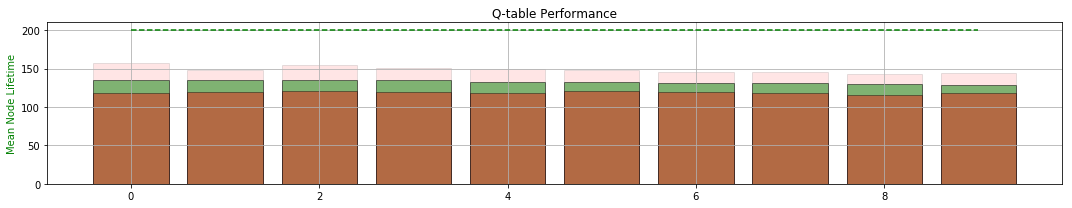

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  3991
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  134.925
Validating... MEAN TIME:  144.44
Validating... MEAN TIME:  147.32
Validating... MEAN TIME:  129.445
Validating... MEAN TIME:  153.405
TRAINING TIME:0:00:37.813818


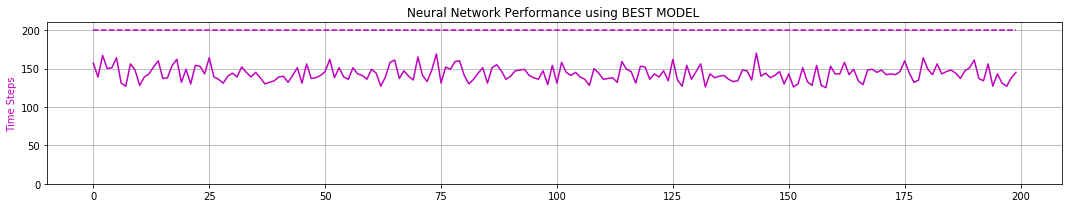

0 -max- [ 0.149  0.751  0.047  0.930  0.549]
0 -min- [-2.399 -2.526 -0.186 -1.205  0.375]

1 -max- [ 0.137  0.635  0.049  0.929  0.600]
1 -min- [-2.400 -2.427 -0.173 -1.056  0.401]

2 -max- [ 0.151  0.632  0.050  0.867  0.650]
2 -min- [-2.400 -2.598 -0.172 -0.958  0.450]

3 -max- [ 0.138  0.813  0.051  0.880  0.700]
3 -min- [-2.400 -2.574 -0.182 -1.156  0.501]

4 -max- [ 0.145  0.817  0.050  0.863  0.748]
4 -min- [-2.400 -2.590 -0.167 -1.092  0.550]

5 -max- [ 0.154  0.801  0.050  0.944  0.799]
5 -min- [-2.398 -2.549 -0.195 -1.219  0.601]

6 -max- [ 0.141  0.633  0.049  0.906  0.849]
6 -min- [-2.400 -2.439 -0.161 -0.972  0.650]

7 -max- [ 0.142  0.821  0.050  0.889  0.900]
7 -min- [-2.399 -2.431 -0.163 -1.052  0.700]

8 -max- [ 0.143  0.774  0.049  1.112  0.925]
8 -min- [-2.399 -2.432 -0.151 -1.094  0.750]

9 -max- [ 0.163  0.786  0.049  1.011  0.925]
9 -min- [-2.400 -2.581 -0.177 -1.193  0.800]



ITERATION # 4
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

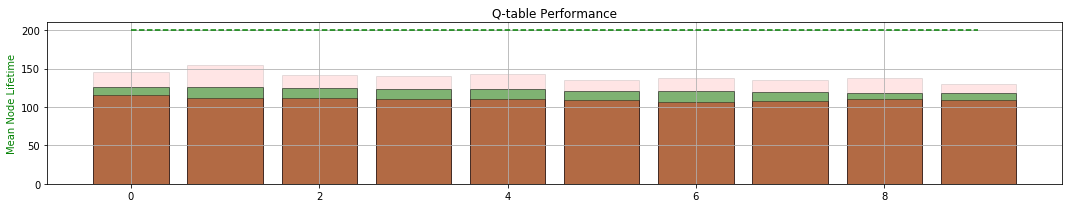

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  4991
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  128.495
Validating... MEAN TIME:  132.395
Validating... MEAN TIME:  117.46
Validating... MEAN TIME:  122.385
Validating... MEAN TIME:  124.675
TRAINING TIME:0:00:35.780862


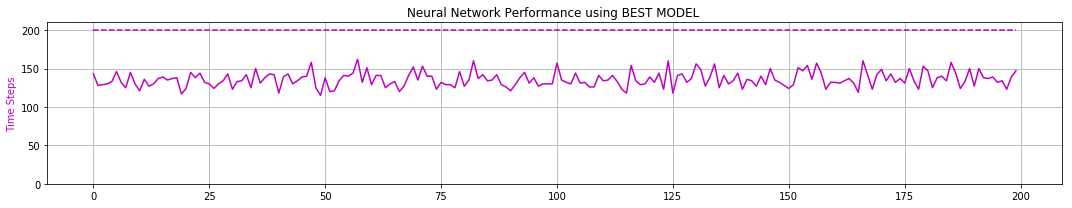

0 -max- [ 0.125  0.756  0.049  0.816  0.549]
0 -min- [-2.399 -2.770 -0.207 -1.187  0.375]

1 -max- [ 0.153  0.609  0.050  0.692  0.600]
1 -min- [-2.400 -2.616 -0.179 -0.893  0.400]

2 -max- [ 0.138  0.627  0.051  0.672  0.650]
2 -min- [-2.399 -2.613 -0.175 -1.028  0.450]

3 -max- [ 0.137  0.621  0.050  0.684  0.700]
3 -min- [-2.400 -2.611 -0.199 -0.883  0.500]

4 -max- [ 0.177  0.790  0.055  1.133  0.750]
4 -min- [-2.400 -2.732 -0.179 -1.157  0.550]

5 -max- [ 0.136  0.780  0.049  0.715  0.800]
5 -min- [-2.400 -2.713 -0.172 -1.114  0.600]

6 -max- [ 0.134  0.633  0.050  0.832  0.850]
6 -min- [-2.398 -2.608 -0.173 -0.966  0.651]

7 -max- [ 0.144  0.758  0.049  0.860  0.899]
7 -min- [-2.400 -2.610 -0.159 -1.174  0.700]

8 -max- [ 0.160  0.632  0.049  0.861  0.925]
8 -min- [-2.400 -2.794 -0.174 -1.320  0.750]

9 -max- [ 0.141  0.749  0.050  0.854  0.925]
9 -min- [-2.400 -2.611 -0.159 -1.159  0.801]



ITERATION # 5
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

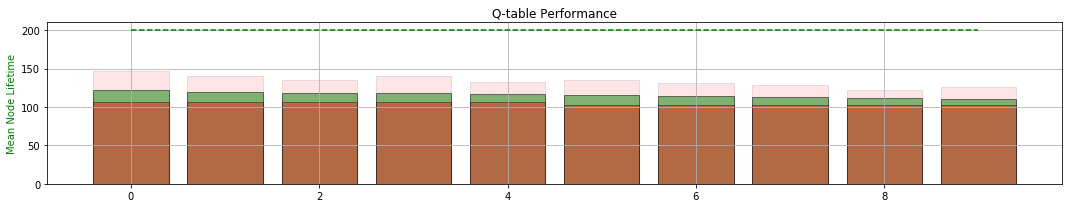

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  5991
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  114.11
Validating... MEAN TIME:  124.845
Validating... MEAN TIME:  110.66
Validating... MEAN TIME:  132.24
Validating... MEAN TIME:  131.395
TRAINING TIME:0:00:34.149831


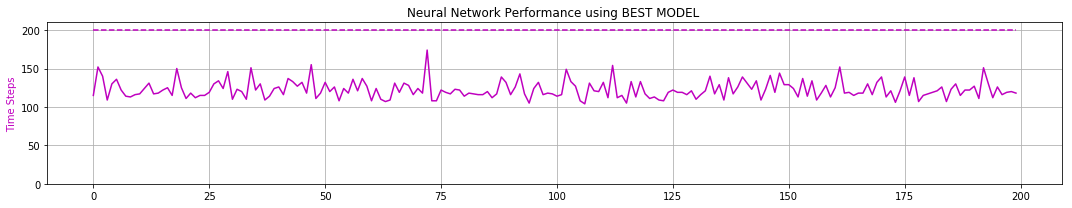

0 -max- [ 0.158  0.560  0.050  0.653  0.549]
0 -min- [-2.399 -2.784 -0.185 -0.871  0.375]

1 -max- [ 0.129  0.601  0.051  0.764  0.600]
1 -min- [-2.400 -2.881 -0.182 -0.888  0.400]

2 -max- [ 0.134  0.439  0.050  0.699  0.649]
2 -min- [-2.399 -2.780 -0.166 -0.793  0.450]

3 -max- [ 0.158  0.628  0.050  0.675  0.700]
3 -min- [-2.399 -2.790 -0.182 -0.927  0.504]

4 -max- [ 0.132  0.618  0.049  0.680  0.750]
4 -min- [-2.400 -2.794 -0.182 -0.910  0.550]

5 -max- [ 0.131  0.744  0.050  0.676  0.800]
5 -min- [-2.400 -2.794 -0.174 -1.119  0.600]

6 -max- [ 0.142  0.633  0.049  0.670  0.849]
6 -min- [-2.400 -2.722 -0.165 -0.899  0.650]

7 -max- [ 0.156  0.632  0.049  0.894  0.900]
7 -min- [-2.400 -2.779 -0.170 -0.907  0.700]

8 -max- [ 0.152  0.765  0.050  0.851  0.925]
8 -min- [-2.400 -2.774 -0.191 -1.149  0.750]

9 -max- [ 0.134  0.632  0.050  0.646  0.925]
9 -min- [-2.400 -2.784 -0.182 -0.924  0.800]



ITERATION # 6
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

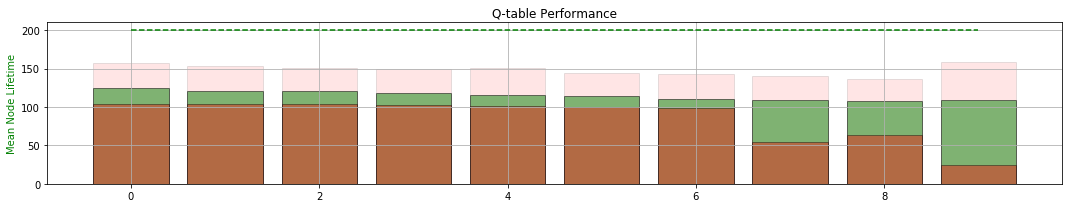

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  6991
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  108.33
Validating... MEAN TIME:  124.16
Validating... MEAN TIME:  109.6
Validating... MEAN TIME:  114.39
Validating... MEAN TIME:  128.255
TRAINING TIME:0:00:32.864313


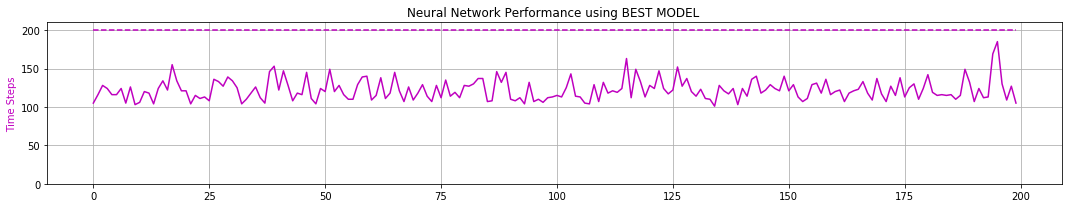

0 -max- [ 0.206  0.570  0.051  0.684  0.550]
0 -min- [-2.400 -2.935 -0.200 -0.797  0.375]

1 -max- [ 0.184  0.572  0.050  0.717  0.600]
1 -min- [-2.400 -2.987 -0.196 -0.758  0.400]

2 -max- [ 0.212  0.592  0.050  0.652  0.649]
2 -min- [-2.399 -2.974 -0.196 -0.792  0.451]

3 -max- [ 0.189  0.579  0.049  0.672  0.699]
3 -min- [-2.400 -2.903 -0.178 -0.865  0.500]

4 -max- [ 0.207  0.612  0.050  0.658  0.750]
4 -min- [-2.400 -2.931 -0.206 -0.898  0.550]

5 -max- [ 0.196  0.745  0.049  0.605  0.800]
5 -min- [-2.400 -2.908 -0.180 -1.117  0.600]

6 -max- [ 0.222  0.604  0.049  0.626  0.850]
6 -min- [-2.400 -2.971 -0.182 -0.915  0.650]

7 -max- [ 0.202  0.635  0.050  0.683  0.900]
7 -min- [-2.400 -2.944 -0.203 -1.080  0.700]

8 -max- [ 0.206  0.633  0.050  0.681  0.925]
8 -min- [-2.400 -3.088 -0.196 -1.143  0.750]

9 -max- [ 0.226  0.595  0.060  0.641  0.925]
9 -min- [-2.400 -3.106 -0.202 -1.107  0.800]



ITERATION # 7
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

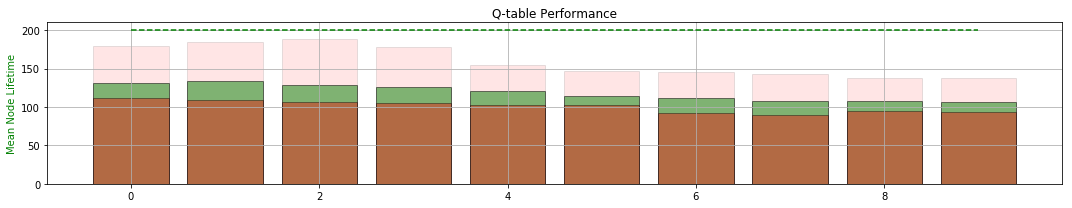

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  7991
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  145.075
Validating... MEAN TIME:  124.93
Validating... MEAN TIME:  108.77
Validating... MEAN TIME:  167.65
Validating... MEAN TIME:  112.885
TRAINING TIME:0:00:35.886654


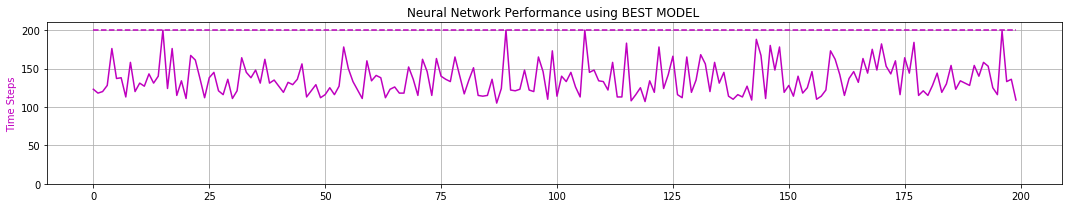

0 -max- [ 0.153  0.573  0.050  0.679  0.550]
0 -min- [-2.399 -3.139 -0.206 -0.801  0.375]

1 -max- [ 0.213  0.565  0.050  0.653  0.600]
1 -min- [-2.400 -3.140 -0.208 -1.004  0.400]

2 -max- [ 0.185  0.566  0.051  0.688  0.650]
2 -min- [-2.399 -3.134 -0.207 -0.801  0.450]

3 -max- [ 0.192  0.617  0.052  0.750  0.700]
3 -min- [-2.400 -3.141 -0.204 -0.794  0.500]

4 -max- [ 0.196  0.742  0.049  0.651  0.749]
4 -min- [-2.400 -3.128 -0.187 -1.191  0.550]

5 -max- [ 0.222  0.578  0.049  0.672  0.800]
5 -min- [-2.400 -3.141 -0.193 -0.906  0.600]

6 -max- [ 0.199  0.580  0.050  0.805  0.849]
6 -min- [-2.400 -3.311 -0.204 -0.931  0.650]

7 -max- [ 0.188  0.752  0.050  0.635  0.900]
7 -min- [-2.400 -3.265 -0.206 -1.024  0.700]

8 -max- [ 0.181  0.824  0.050  0.623  0.925]
8 -min- [-2.400 -3.261 -0.192 -1.229  0.752]

9 -max- [ 0.225  0.818  0.048  0.637  0.925]
9 -min- [-2.400 -3.298 -0.198 -1.192  0.801]



ITERATION # 8
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

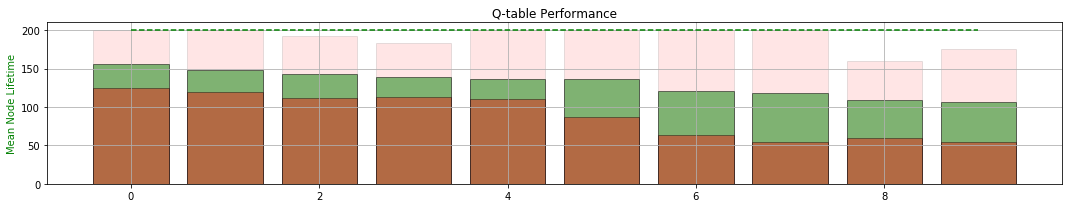

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  8965
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  133.29
Validating... MEAN TIME:  130.835
Validating... MEAN TIME:  166.11
Validating... MEAN TIME:  166.78
Validating... MEAN TIME:  176.52
TRAINING TIME:0:00:42.348073


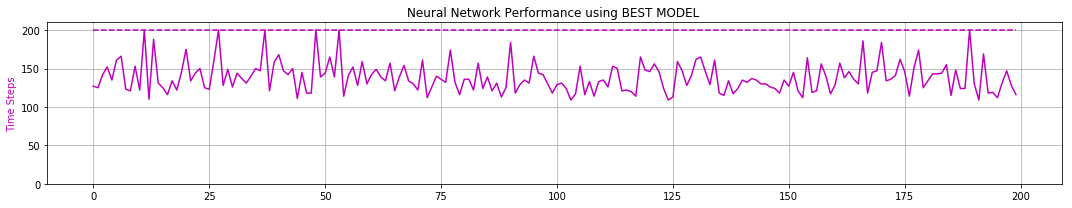

0 -max- [ 0.202  0.559  0.050  0.697  0.550]
0 -min- [-2.399 -3.080 -0.206 -0.902  0.375]

1 -max- [ 0.172  0.433  0.049  0.690  0.599]
1 -min- [-2.399 -3.094 -0.196 -1.030  0.401]

2 -max- [ 0.195  0.547  0.052  0.739  0.650]
2 -min- [-2.400 -3.127 -0.209 -1.021  0.451]

3 -max- [ 0.200  0.619  0.049  0.688  0.699]
3 -min- [-2.400 -3.140 -0.206 -0.854  0.500]

4 -max- [ 0.259  0.621  0.049  0.666  0.750]
4 -min- [-2.400 -3.124 -0.196 -0.965  0.553]

5 -max- [ 0.731  1.068  0.204  0.691  0.799]
5 -min- [-2.398 -3.121 -0.199 -1.114  0.600]

6 -max- [ 0.962  1.271  0.208  0.733  0.850]
6 -min- [-2.400 -3.139 -0.206 -0.871  0.651]

7 -max- [ 0.750  1.265  0.208  0.876  0.899]
7 -min- [-2.400 -3.158 -0.207 -0.939  0.701]

8 -max- [ 0.626  1.102  0.208  0.829  0.925]
8 -min- [-2.400 -3.297 -0.198 -0.938  0.751]

9 -max- [ 0.546  1.076  0.209  0.966  0.925]
9 -min- [-2.400 -3.164 -0.195 -1.190  0.800]



ITERATION # 9
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in I

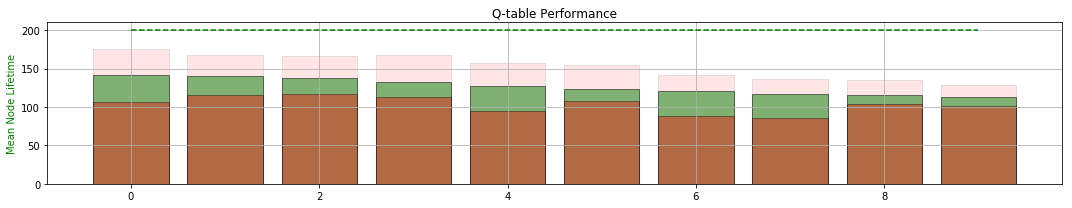

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  9965
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  126.015
Validating... MEAN TIME:  182.805
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  183.215
Validating... MEAN TIME:  160.91
TRAINING TIME:0:00:44.829913


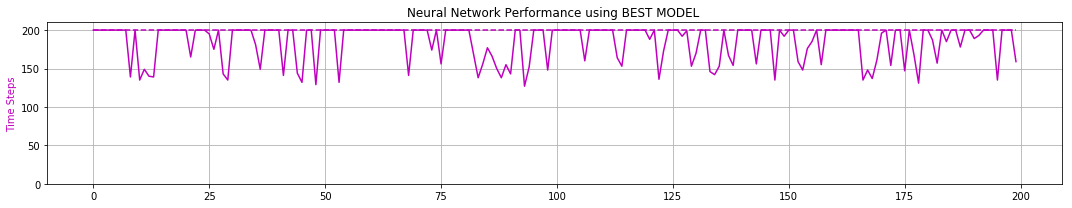

0 -max- [ 0.107  0.811  0.049  0.712  0.550]
0 -min- [-2.400 -3.325 -0.209 -1.194  0.375]

1 -max- [ 0.108  0.821  0.050  0.848  0.600]
1 -min- [-2.399 -3.310 -0.209 -1.052  0.400]

2 -max- [ 0.110  0.633  0.049  0.779  0.650]
2 -min- [-2.399 -3.291 -0.208 -0.922  0.450]

3 -max- [ 0.120  0.786  0.049  0.744  0.700]
3 -min- [-2.400 -3.319 -0.207 -1.132  0.500]

4 -max- [ 0.110  0.825  0.050  0.760  0.750]
4 -min- [-2.397 -3.281 -0.209 -1.162  0.550]

5 -max- [ 0.108  0.820  0.053  0.714  0.799]
5 -min- [-2.400 -3.281 -0.207 -1.223  0.600]

6 -max- [ 0.119  0.925  0.054  0.736  0.849]
6 -min- [-2.400 -3.122 -0.206 -1.382  0.651]

7 -max- [ 0.128  0.828  0.048  0.707  0.900]
7 -min- [-2.400 -3.123 -0.207 -1.172  0.701]

8 -max- [ 0.129  0.826  0.049  0.726  0.925]
8 -min- [-2.400 -3.136 -0.195 -1.190  0.750]

9 -max- [ 0.133  1.004  0.047  0.733  0.925]
9 -min- [-2.400 -3.102 -0.204 -1.365  0.800]



ITERATION # 10
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

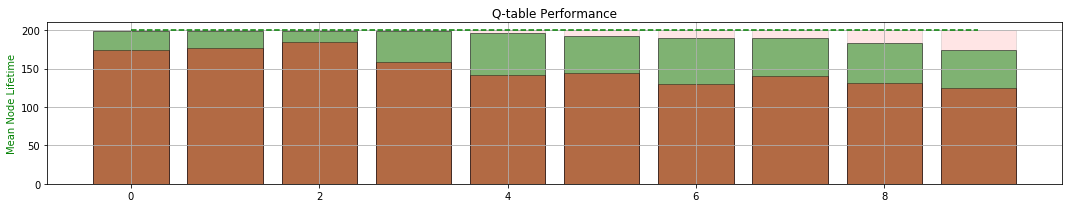

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  10237
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  127.18
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  139.385
Validating... MEAN TIME:  164.25
TRAINING TIME:0:00:44.209385


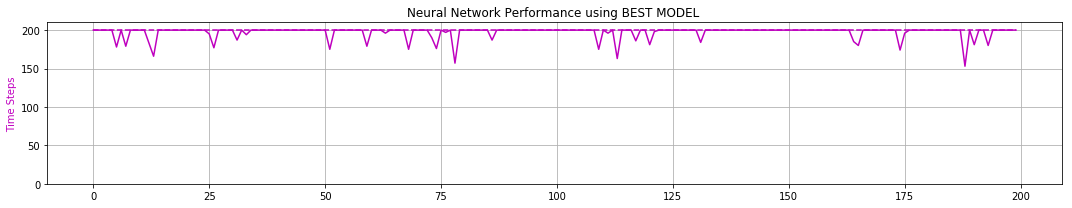

0 -max- [ 0.228  0.630  0.055  0.732  0.550]
0 -min- [-2.396 -2.979 -0.200 -1.009  0.375]

1 -max- [ 0.237  0.569  0.053  0.743  0.600]
1 -min- [-2.389 -2.983 -0.197 -0.855  0.401]

2 -max- [ 0.356  0.603  0.049  0.774  0.649]
2 -min- [-2.398 -2.971 -0.193 -1.033  0.450]

3 -max- [ 0.336  0.603  0.050  0.736  0.700]
3 -min- [-2.388 -2.984 -0.192 -1.021  0.501]

4 -max- [ 0.350  0.817  0.052  0.933  0.750]
4 -min- [-2.399 -2.976 -0.195 -1.105  0.550]

5 -max- [ 0.381  0.625  0.050  0.731  0.800]
5 -min- [-2.400 -2.982 -0.201 -1.229  0.601]

6 -max- [ 0.511  0.575  0.048  0.740  0.850]
6 -min- [-2.399 -3.080 -0.203 -1.301  0.650]

7 -max- [ 0.380  0.601  0.049  0.716  0.900]
7 -min- [-2.399 -2.982 -0.190 -1.128  0.700]

8 -max- [ 0.795  0.788  0.071  0.717  0.925]
8 -min- [-2.399 -3.072 -0.205 -1.070  0.752]

9 -max- [ 2.367  2.058  0.190  0.928  0.925]
9 -min- [-2.399 -3.097 -0.199 -1.177  0.801]



ITERATION # 11
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

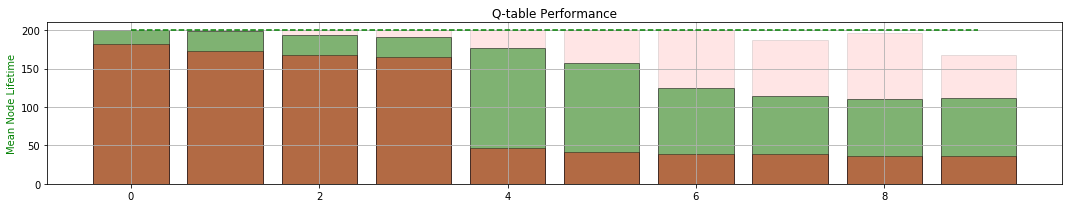

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  10898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  147.99
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  123.26
Validating... MEAN TIME:  167.285
Validating... MEAN TIME:  146.345
TRAINING TIME:0:00:41.055159


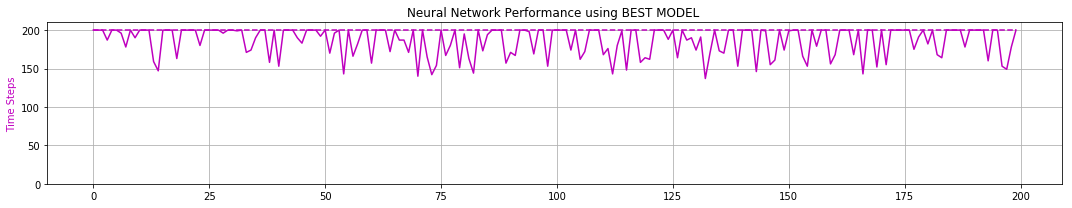

0 -max- [ 0.116  0.603  0.054  0.708  0.549]
0 -min- [-2.396 -2.806 -0.199 -1.007  0.375]

1 -max- [ 0.134  0.616  0.049  0.737  0.600]
1 -min- [-2.398 -2.805 -0.187 -0.900  0.401]

2 -max- [ 0.117  0.632  0.050  0.766  0.650]
2 -min- [-2.400 -2.809 -0.198 -1.056  0.450]

3 -max- [ 0.120  0.542  0.050  0.720  0.699]
3 -min- [-2.399 -2.986 -0.199 -1.364  0.500]

4 -max- [ 0.404  1.260  0.209  0.723  0.750]
4 -min- [-2.399 -2.802 -0.199 -1.080  0.550]

5 -max- [ 0.371  1.142  0.209  0.904  0.800]
5 -min- [-2.399 -3.098 -0.198 -1.129  0.600]

6 -max- [ 0.329  1.123  0.209  0.938  0.849]
6 -min- [-2.398 -2.908 -0.182 -1.047  0.650]

7 -max- [ 0.329  1.139  0.209  0.760  0.900]
7 -min- [-2.400 -2.808 -0.173 -1.053  0.700]

8 -max- [ 0.385  1.144  0.209  0.814  0.925]
8 -min- [-2.399 -2.777 -0.181 -1.038  0.750]

9 -max- [ 0.346  1.116  0.209  0.928  0.925]
9 -min- [-2.400 -2.925 -0.196 -1.435  0.800]



ITERATION # 12
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

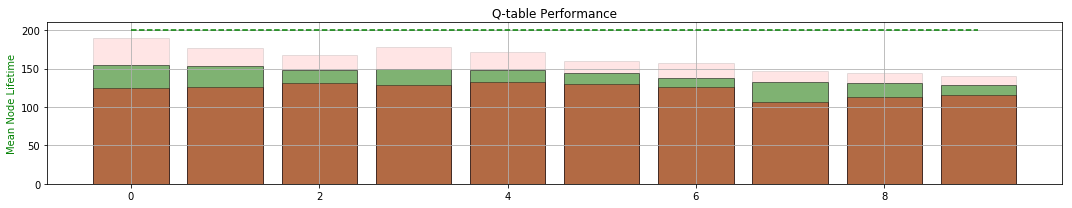

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  11898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  143.495
Validating... MEAN TIME:  130.905
Validating... MEAN TIME:  150.06
Validating... MEAN TIME:  129.305
Validating... MEAN TIME:  157.935
TRAINING TIME:0:00:37.864115


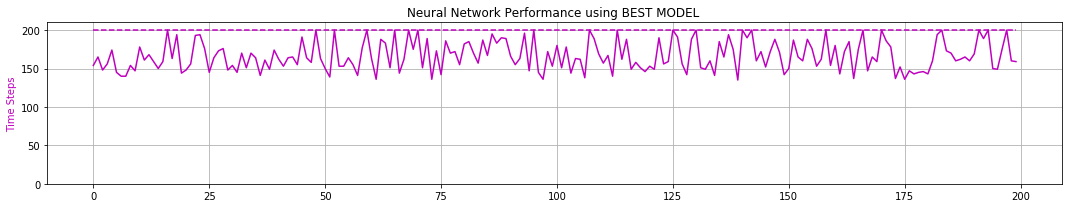

0 -max- [ 0.150  0.827  0.049  1.055  0.550]
0 -min- [-2.399 -2.972 -0.206 -1.176  0.375]

1 -max- [ 0.147  0.825  0.050  1.029  0.599]
1 -min- [-2.400 -2.959 -0.209 -1.190  0.401]

2 -max- [ 0.128  0.820  0.050  0.896  0.650]
2 -min- [-2.399 -2.977 -0.208 -1.145  0.450]

3 -max- [ 0.130  1.015  0.050  1.010  0.700]
3 -min- [-2.400 -2.983 -0.205 -1.362  0.500]

4 -max- [ 0.135  0.984  0.048  1.052  0.749]
4 -min- [-2.400 -2.973 -0.205 -1.446  0.550]

5 -max- [ 0.150  0.826  0.049  1.010  0.799]
5 -min- [-2.399 -2.969 -0.197 -1.200  0.600]

6 -max- [ 0.146  1.004  0.047  0.885  0.850]
6 -min- [-2.400 -2.950 -0.203 -1.425  0.651]

7 -max- [ 0.130  0.946  0.048  0.992  0.899]
7 -min- [-2.400 -2.965 -0.206 -1.459  0.701]

8 -max- [ 0.149  0.827  0.048  1.021  0.925]
8 -min- [-2.400 -3.087 -0.196 -1.307  0.751]

9 -max- [ 0.134  0.821  0.049  1.129  0.925]
9 -min- [-2.400 -3.150 -0.187 -1.283  0.800]



ITERATION # 13
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

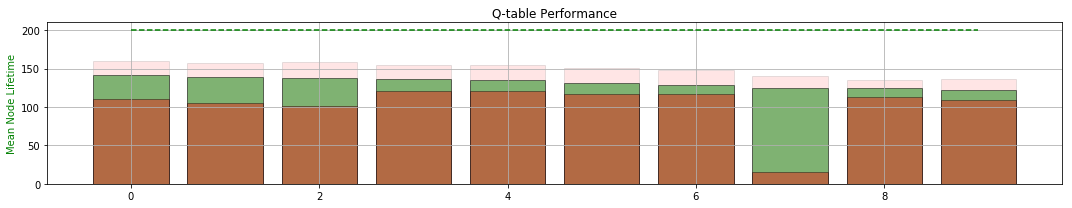

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  12898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  117.485
Validating... MEAN TIME:  163.215
Validating... MEAN TIME:  121.715
Validating... MEAN TIME:  178.97
Validating... MEAN TIME:  165.035
TRAINING TIME:0:00:39.527656


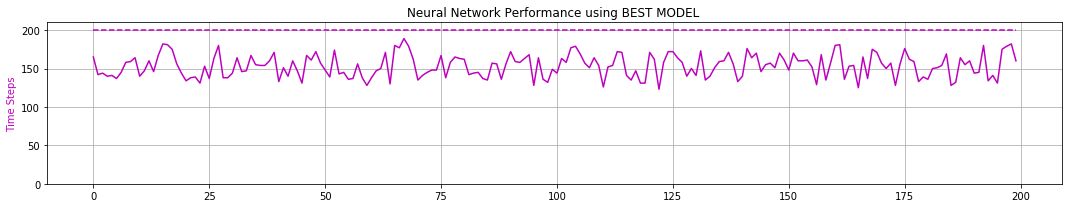

0 -max- [ 0.152  0.944  0.050  1.288  0.549]
0 -min- [-2.400 -2.988 -0.209 -1.353  0.375]

1 -max- [ 0.146  1.021  0.060  1.606  0.600]
1 -min- [-2.400 -2.984 -0.209 -1.359  0.400]

2 -max- [ 0.152  1.015  0.060  1.463  0.650]
2 -min- [-2.399 -2.986 -0.209 -1.391  0.451]

3 -max- [ 0.162  0.947  0.048  1.259  0.700]
3 -min- [-2.400 -3.074 -0.209 -1.420  0.500]

4 -max- [ 0.164  0.826  0.049  1.306  0.749]
4 -min- [-2.399 -3.097 -0.209 -1.202  0.551]

5 -max- [ 0.166  1.004  0.047  1.273  0.800]
5 -min- [-2.400 -2.986 -0.208 -1.365  0.602]

6 -max- [ 0.145  0.828  0.048  1.322  0.849]
6 -min- [-2.399 -2.989 -0.204 -1.239  0.650]

7 -max- [ 0.169  0.933  0.048  1.331  0.899]
7 -min- [-2.400 -2.982 -0.202 -1.400  0.700]

8 -max- [ 0.158  0.821  0.049  1.341  0.925]
8 -min- [-2.400 -3.153 -0.199 -1.221  0.750]

9 -max- [ 0.169  0.943  0.050  1.422  0.925]
9 -min- [-2.400 -2.987 -0.196 -1.356  0.800]



ITERATION # 14
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

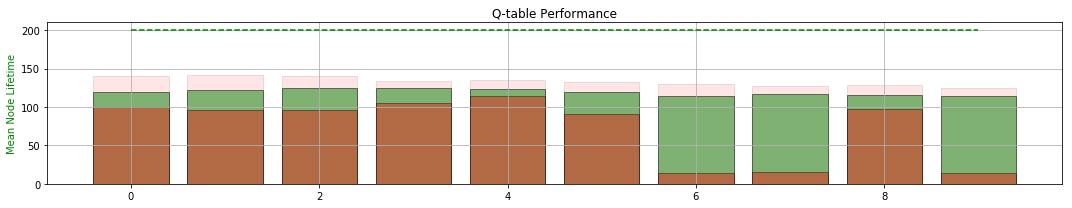

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  13898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  113.765
Validating... MEAN TIME:  127.535
Validating... MEAN TIME:  149.84
Validating... MEAN TIME:  125.145
Validating... MEAN TIME:  120.355
TRAINING TIME:0:00:35.250984


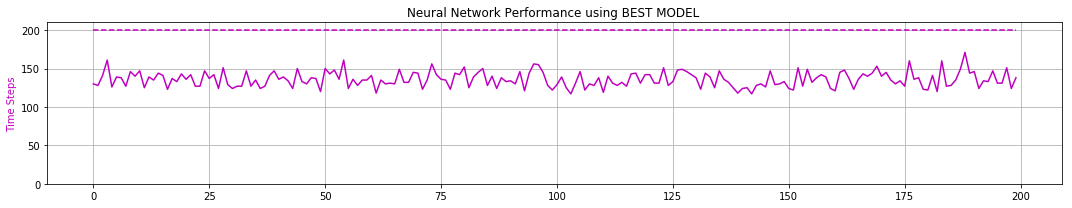

0 -max- [ 0.161  0.827  0.050  1.268  0.550]
0 -min- [-2.400 -3.100 -0.209 -1.193  0.375]

1 -max- [ 0.173  1.015  0.050  1.310  0.600]
1 -min- [-2.400 -2.965 -0.209 -1.365  0.401]

2 -max- [ 0.176  0.936  0.055  1.305  0.650]
2 -min- [-2.400 -2.942 -0.209 -1.365  0.450]

3 -max- [ 0.185  0.826  0.049  1.296  0.700]
3 -min- [-2.400 -2.984 -0.209 -1.237  0.500]

4 -max- [ 0.180  1.004  0.047  1.320  0.750]
4 -min- [-2.400 -2.982 -0.209 -1.365  0.550]

5 -max- [ 0.166  1.018  0.048  1.427  0.800]
5 -min- [-2.399 -3.103 -0.209 -1.376  0.601]

6 -max- [ 0.181  0.828  0.048  1.294  0.850]
6 -min- [-2.400 -2.959 -0.209 -1.629  0.651]

7 -max- [ 0.167  0.827  0.049  1.427  0.898]
7 -min- [-2.400 -2.982 -0.208 -1.276  0.700]

8 -max- [ 0.183  0.977  0.050  1.494  0.925]
8 -min- [-2.399 -3.086 -0.206 -1.429  0.750]

9 -max- [ 0.189  1.023  0.048  1.553  0.925]
9 -min- [-2.400 -2.967 -0.205 -1.508  0.801]



ITERATION # 15
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

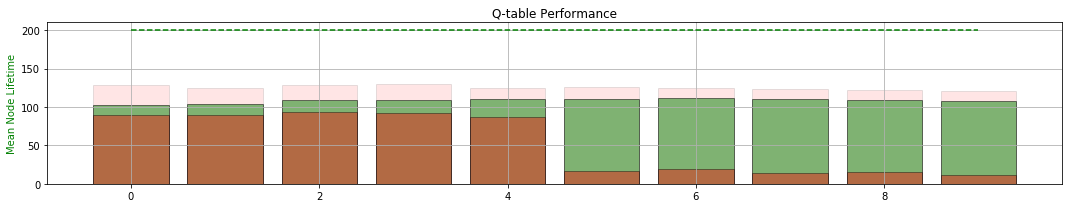

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  14898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  136.11
Validating... MEAN TIME:  138.64
Validating... MEAN TIME:  121.155
Validating... MEAN TIME:  146.26
Validating... MEAN TIME:  170.62
TRAINING TIME:0:00:38.249899


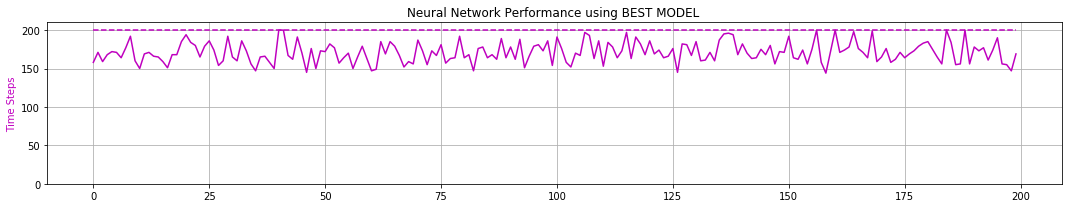

0 -max- [ 0.173  1.015  0.050  1.324  0.550]
0 -min- [-2.349 -2.900 -0.209 -1.364  0.375]

1 -max- [ 0.184  0.828  0.048  1.438  0.600]
1 -min- [-2.399 -3.096 -0.209 -1.238  0.400]

2 -max- [ 0.185  0.826  0.049  1.328  0.649]
2 -min- [-2.399 -3.114 -0.209 -1.254  0.451]

3 -max- [ 0.180  1.004  0.049  1.299  0.700]
3 -min- [-2.398 -3.142 -0.209 -1.378  0.500]

4 -max- [ 0.166  1.018  0.048  1.426  0.750]
4 -min- [-2.400 -3.165 -0.209 -1.425  0.550]

5 -max- [ 0.189  0.995  0.048  1.482  0.800]
5 -min- [-2.400 -3.157 -0.209 -1.483  0.601]

6 -max- [ 0.164  0.955  0.049  1.384  0.850]
6 -min- [-2.400 -3.137 -0.209 -1.492  0.651]

7 -max- [ 0.183  1.008  0.050  1.357  0.899]
7 -min- [-2.400 -3.152 -0.209 -1.429  0.700]

8 -max- [ 0.189  1.154  0.048  1.303  0.925]
8 -min- [-2.400 -3.146 -0.208 -1.685  0.752]

9 -max- [ 0.182  1.017  0.048  1.521  0.925]
9 -min- [-2.399 -3.130 -0.209 -1.536  0.800]



ITERATION # 16
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

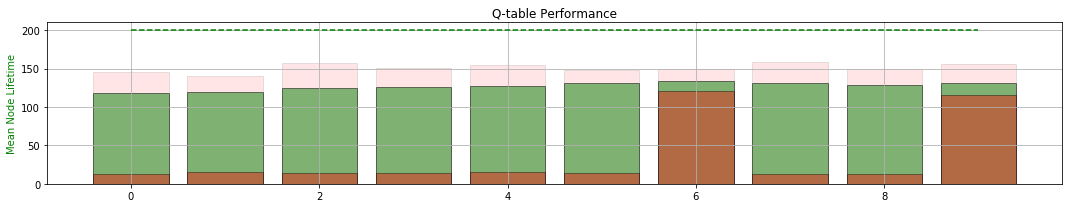

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  15898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  129.015
Validating... MEAN TIME:  132.52
Validating... MEAN TIME:  141.95
Validating... MEAN TIME:  136.685
Validating... MEAN TIME:  144.62
TRAINING TIME:0:00:38.468274


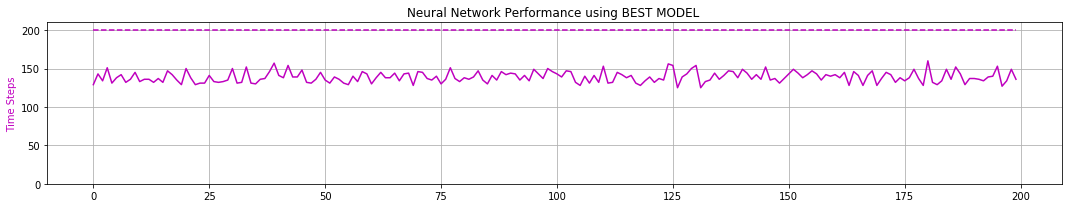

0 -max- [ 0.210  1.206  0.080  1.658  0.550]
0 -min- [-2.377 -2.796 -0.209 -1.678  0.375]

1 -max- [ 0.193  1.156  0.094  1.837  0.599]
1 -min- [-2.392 -2.794 -0.209 -1.663  0.400]

2 -max- [ 0.188  1.199  0.106  1.897  0.650]
2 -min- [-2.397 -2.945 -0.209 -1.674  0.450]

3 -max- [ 0.173  1.018  0.114  1.928  0.700]
3 -min- [-2.397 -2.892 -0.209 -1.624  0.500]

4 -max- [ 0.185  1.170  0.110  1.945  0.750]
4 -min- [-2.399 -2.792 -0.209 -1.673  0.550]

5 -max- [ 0.173  1.014  0.111  1.772  0.799]
5 -min- [-2.400 -2.793 -0.209 -1.749  0.600]

6 -max- [ 0.196  1.179  0.146  1.898  0.850]
6 -min- [-2.400 -2.884 -0.208 -1.765  0.651]

7 -max- [ 0.184  1.136  0.133  1.919  0.899]
7 -min- [-2.399 -2.795 -0.208 -1.851  0.700]

8 -max- [ 0.182  1.187  0.128  1.894  0.925]
8 -min- [-2.400 -2.767 -0.209 -1.785  0.750]

9 -max- [ 0.181  1.211  0.149  1.895  0.925]
9 -min- [-2.400 -2.776 -0.207 -1.785  0.800]



ITERATION # 17
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

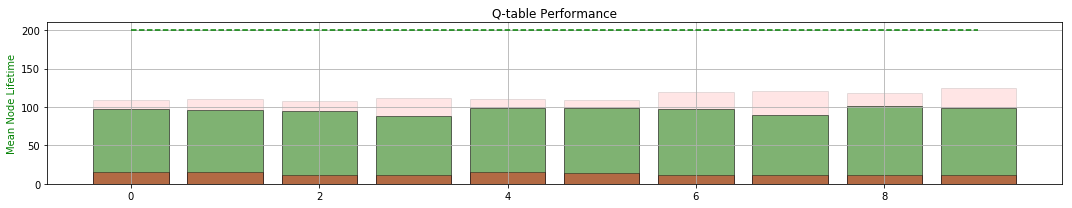

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  16898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  126.535
Validating... MEAN TIME:  122.19
Validating... MEAN TIME:  128.48
Validating... MEAN TIME:  134.615
Validating... MEAN TIME:  148.625
TRAINING TIME:0:00:37.293309


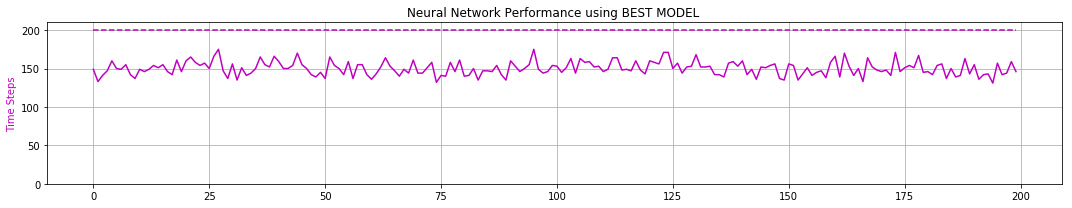

0 -max- [ 0.201  1.156  0.049  1.704  0.549]
0 -min- [-1.610 -2.152 -0.209 -1.666  0.375]

1 -max- [ 0.199  1.199  0.047  1.633  0.600]
1 -min- [-1.630 -2.061 -0.209 -1.680  0.400]

2 -max- [ 0.181  1.213  0.048  1.577  0.649]
2 -min- [-1.682 -2.182 -0.209 -1.801  0.451]

3 -max- [ 0.192  1.387  0.056  1.642  0.700]
3 -min- [-1.804 -2.211 -0.209 -2.037  0.501]

4 -max- [ 0.180  1.159  0.049  1.666  0.749]
4 -min- [-1.852 -2.351 -0.209 -1.714  0.550]

5 -max- [ 0.206  1.179  0.050  1.587  0.797]
5 -min- [-1.898 -2.361 -0.209 -1.683  0.600]

6 -max- [ 0.204  1.218  0.048  1.625  0.850]
6 -min- [-2.391 -2.780 -0.209 -1.698  0.650]

7 -max- [ 0.198  1.187  0.051  1.805  0.900]
7 -min- [-2.398 -2.891 -0.209 -1.677  0.701]

8 -max- [ 0.188  1.211  0.046  1.605  0.925]
8 -min- [-2.395 -2.785 -0.209 -1.682  0.750]

9 -max- [ 0.204  1.191  0.065  1.849  0.925]
9 -min- [-2.400 -2.920 -0.209 -1.683  0.800]



ITERATION # 18
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

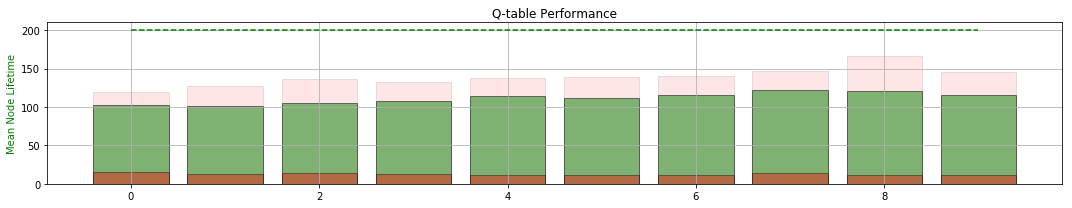

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  17898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  122.575
Validating... MEAN TIME:  121.09
Validating... MEAN TIME:  114.6
Validating... MEAN TIME:  133.88
Validating... MEAN TIME:  143.175
TRAINING TIME:0:00:36.009441


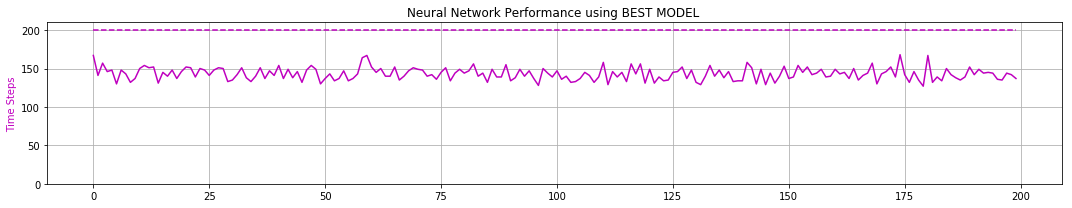

0 -max- [ 0.188  1.011  0.091  1.903  0.550]
0 -min- [-1.676 -2.025 -0.209 -1.540  0.375]

1 -max- [ 0.181  1.018  0.090  1.878  0.599]
1 -min- [-1.851 -2.226 -0.209 -1.619  0.400]

2 -max- [ 0.197  1.130  0.138  1.935  0.650]
2 -min- [-1.959 -2.241 -0.209 -1.664  0.450]

3 -max- [ 0.166  1.014  0.119  1.764  0.699]
3 -min- [-2.389 -2.923 -0.209 -1.643  0.500]

4 -max- [ 0.190  1.179  0.138  2.096  0.750]
4 -min- [-2.399 -3.090 -0.209 -2.005  0.552]

5 -max- [ 0.204  1.218  0.124  1.974  0.799]
5 -min- [-2.400 -3.071 -0.209 -1.679  0.600]

6 -max- [ 0.190  1.218  0.105  1.944  0.850]
6 -min- [-2.400 -3.136 -0.209 -1.946  0.651]

7 -max- [ 0.188  1.211  0.140  1.950  0.900]
7 -min- [-2.399 -3.111 -0.209 -1.909  0.700]

8 -max- [ 0.204  1.579  0.207  2.226  0.925]
8 -min- [-2.398 -3.135 -0.209 -2.218  0.750]

9 -max- [ 0.192  1.338  0.170  2.036  0.925]
9 -min- [-2.400 -3.106 -0.209 -2.171  0.801]



ITERATION # 19
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

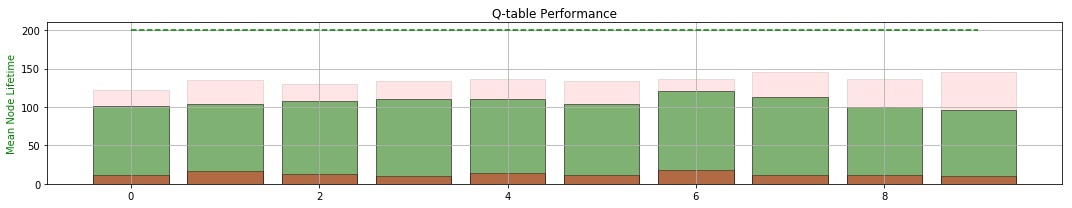

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  18898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  146.04
Validating... MEAN TIME:  124.3
Validating... MEAN TIME:  137.28
Validating... MEAN TIME:  121.89
Validating... MEAN TIME:  134.515
TRAINING TIME:0:00:37.164069


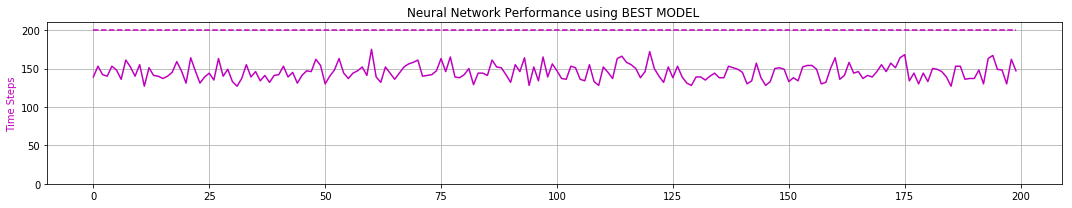

0 -max- [ 0.181  1.020  0.111  1.940  0.549]
0 -min- [-1.839 -2.235 -0.209 -1.663  0.375]

1 -max- [ 0.197  1.023  0.093  1.839  0.599]
1 -min- [-2.374 -2.924 -0.209 -1.599  0.401]

2 -max- [ 0.172  1.014  0.058  1.812  0.650]
2 -min- [-2.398 -3.119 -0.209 -1.575  0.450]

3 -max- [ 0.198  1.179  0.113  1.948  0.700]
3 -min- [-2.397 -3.125 -0.209 -1.669  0.501]

4 -max- [ 0.204  1.153  0.120  1.970  0.749]
4 -min- [-2.400 -3.125 -0.209 -1.679  0.550]

5 -max- [ 0.204  1.220  0.171  2.215  0.799]
5 -min- [-2.400 -3.134 -0.209 -2.127  0.600]

6 -max- [ 0.188  1.187  0.101  1.930  0.850]
6 -min- [-2.400 -3.134 -0.209 -1.682  0.650]

7 -max- [ 0.204  1.191  0.135  2.036  0.900]
7 -min- [-2.400 -3.140 -0.209 -1.914  0.701]

8 -max- [ 0.207  1.208  0.115  1.948  0.925]
8 -min- [-2.400 -3.134 -0.209 -1.703  0.751]

9 -max- [ 0.215  1.327  0.159  1.930  0.925]
9 -min- [-2.399 -2.982 -0.209 -2.197  0.801]



ITERATION # 20
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

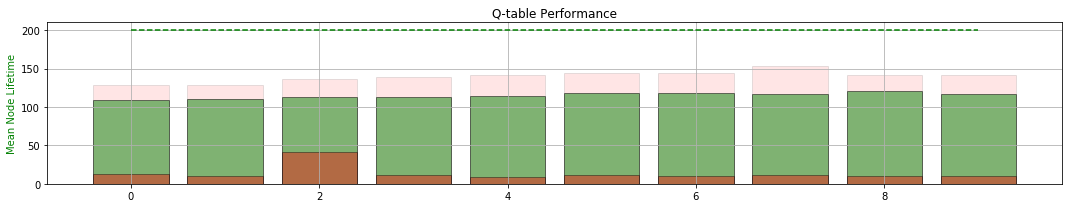

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  19898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  151.2
Validating... MEAN TIME:  136.145
Validating... MEAN TIME:  131.44
Validating... MEAN TIME:  134.265
Validating... MEAN TIME:  128.635
TRAINING TIME:0:00:36.983284


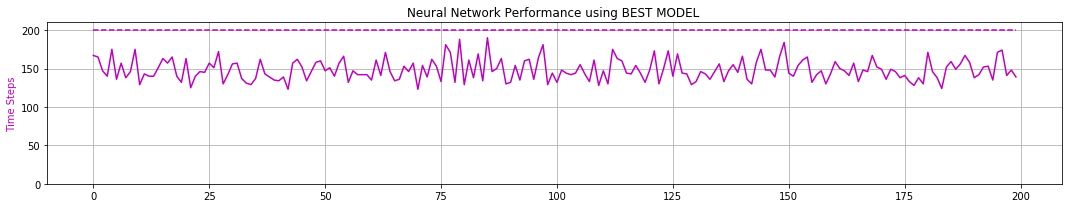

0 -max- [ 0.200  1.010  0.125  1.924  0.550]
0 -min- [-1.855 -2.188 -0.209 -1.819  0.375]

1 -max- [ 0.169  1.014  0.095  1.892  0.600]
1 -min- [-2.199 -2.607 -0.209 -1.769  0.400]

2 -max- [ 0.190  1.010  0.140  2.053  0.650]
2 -min- [-2.392 -2.982 -0.209 -1.673  0.450]

3 -max- [ 0.197  1.199  0.139  1.960  0.699]
3 -min- [-2.400 -3.074 -0.209 -1.760  0.500]

4 -max- [ 0.190  1.410  0.158  1.944  0.748]
4 -min- [-2.399 -3.131 -0.209 -2.196  0.550]

5 -max- [ 0.182  1.016  0.138  1.943  0.800]
5 -min- [-2.399 -3.141 -0.209 -1.666  0.601]

6 -max- [ 0.196  1.214  0.145  2.111  0.850]
6 -min- [-2.400 -3.134 -0.209 -1.984  0.650]

7 -max- [ 0.191  1.545  0.194  1.957  0.899]
7 -min- [-2.399 -2.975 -0.209 -2.225  0.700]

8 -max- [ 0.209  1.202  0.147  1.991  0.925]
8 -min- [-2.399 -2.983 -0.209 -1.721  0.751]

9 -max- [ 0.198  1.203  0.201  2.145  0.925]
9 -min- [-2.400 -2.976 -0.208 -1.955  0.801]



ITERATION # 21
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

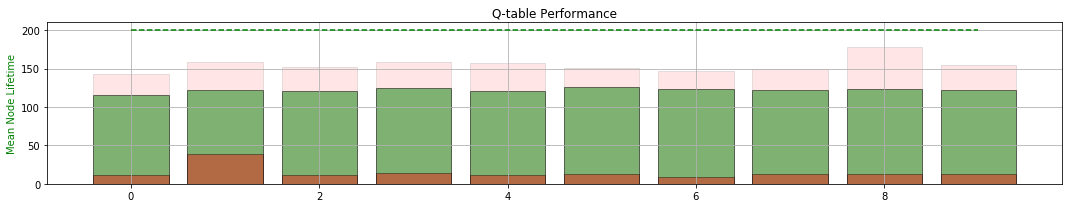

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  20898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  125.705
Validating... MEAN TIME:  134.015
Validating... MEAN TIME:  139.775
Validating... MEAN TIME:  131.665
Validating... MEAN TIME:  126.435
TRAINING TIME:0:00:36.276087


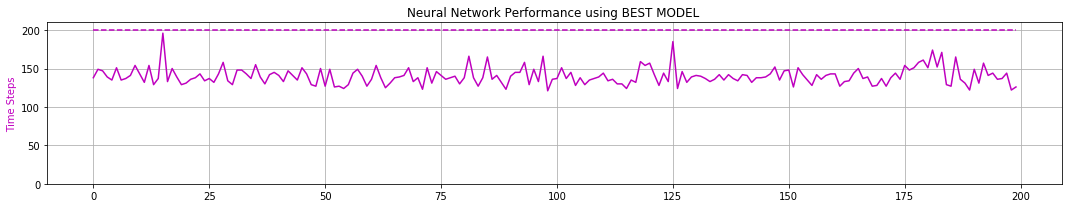

0 -max- [ 0.166  1.184  0.163  1.914  0.549]
0 -min- [-2.391 -2.970 -0.209 -1.965  0.375]

1 -max- [ 0.183  1.388  0.181  2.016  0.600]
1 -min- [-2.399 -3.093 -0.209 -2.176  0.401]

2 -max- [ 0.200  1.524  0.202  2.211  0.650]
2 -min- [-2.394 -3.141 -0.209 -2.215  0.451]

3 -max- [ 0.190  1.420  0.160  1.990  0.700]
3 -min- [-2.400 -3.286 -0.209 -2.237  0.500]

4 -max- [ 0.180  1.579  0.205  2.242  0.749]
4 -min- [-2.399 -3.140 -0.209 -2.224  0.551]

5 -max- [ 0.196  1.189  0.150  2.104  0.799]
5 -min- [-2.400 -3.130 -0.209 -1.941  0.600]

6 -max- [ 0.199  1.167  0.138  1.960  0.849]
6 -min- [-2.398 -3.178 -0.209 -1.671  0.650]

7 -max- [ 0.226  1.397  0.164  2.129  0.900]
7 -min- [-2.399 -3.176 -0.209 -1.960  0.700]

8 -max- [ 0.177  1.575  0.183  2.041  0.925]
8 -min- [-2.399 -3.176 -0.209 -2.198  0.750]

9 -max- [ 0.198  1.596  0.196  2.087  0.925]
9 -min- [-2.399 -3.177 -0.209 -2.227  0.801]



ITERATION # 22
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

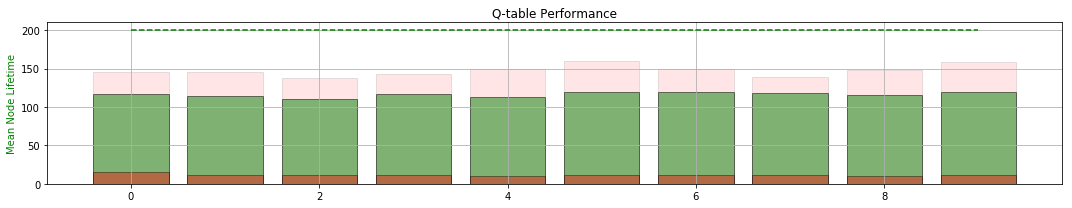

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  21898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  143.365
Validating... MEAN TIME:  123.985
Validating... MEAN TIME:  120.3
Validating... MEAN TIME:  120.395
Validating... MEAN TIME:  137.755
TRAINING TIME:0:00:36.859713


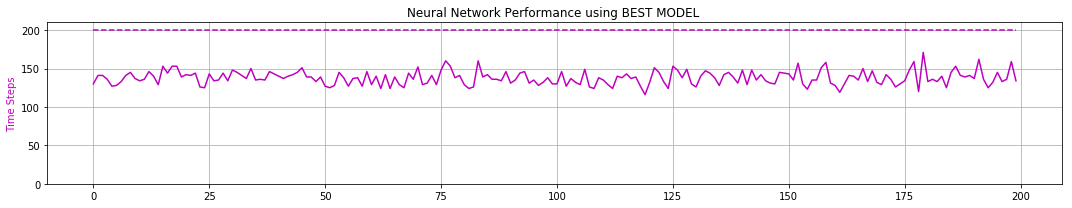

0 -max- [ 0.198  1.374  0.154  2.048  0.550]
0 -min- [-2.398 -3.105 -0.209 -2.099  0.375]

1 -max- [ 0.192  1.331  0.158  1.964  0.599]
1 -min- [-2.397 -3.111 -0.209 -2.038  0.401]

2 -max- [ 0.190  1.024  0.123  1.952  0.650]
2 -min- [-2.399 -3.125 -0.209 -1.826  0.450]

3 -max- [ 0.182  1.210  0.133  1.982  0.700]
3 -min- [-2.398 -3.140 -0.209 -1.682  0.500]

4 -max- [ 0.204  1.517  0.180  2.157  0.750]
4 -min- [-2.400 -3.134 -0.209 -2.219  0.553]

5 -max- [ 0.186  1.357  0.165  2.066  0.800]
5 -min- [-2.400 -3.157 -0.209 -2.168  0.600]

6 -max- [ 0.209  1.215  0.147  2.117  0.850]
6 -min- [-2.400 -3.121 -0.209 -1.858  0.651]

7 -max- [ 0.189  1.207  0.184  2.193  0.900]
7 -min- [-2.400 -3.159 -0.207 -1.799  0.701]

8 -max- [ 0.185  1.207  0.153  1.961  0.925]
8 -min- [-2.399 -3.295 -0.209 -1.812  0.750]

9 -max- [ 0.208  1.353  0.179  1.959  0.925]
9 -min- [-2.398 -3.287 -0.209 -1.973  0.800]



ITERATION # 23
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

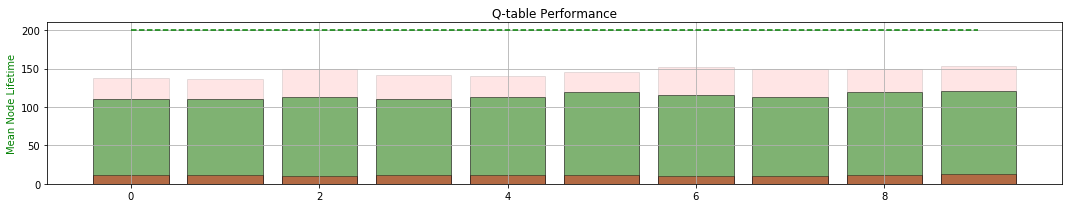

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  22898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  158.135
Validating... MEAN TIME:  126.53
Validating... MEAN TIME:  127.56
Validating... MEAN TIME:  138.8
Validating... MEAN TIME:  130.95
TRAINING TIME:0:00:38.043718


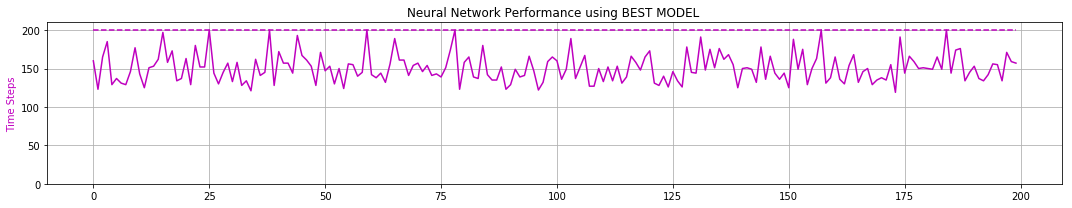

0 -max- [ 0.192  1.733  0.201  2.156  0.549]
0 -min- [-2.399 -3.115 -0.209 -2.402  0.375]

1 -max- [ 0.190  1.407  0.141  2.033  0.600]
1 -min- [-2.396 -3.114 -0.209 -2.131  0.400]

2 -max- [ 0.182  1.591  0.197  2.206  0.650]
2 -min- [-2.392 -3.292 -0.209 -2.251  0.450]

3 -max- [ 0.204  1.367  0.158  1.958  0.700]
3 -min- [-2.399 -3.308 -0.209 -2.217  0.501]

4 -max- [ 0.186  1.208  0.121  2.041  0.750]
4 -min- [-2.399 -3.317 -0.209 -1.934  0.551]

5 -max- [ 0.209  1.202  0.198  2.074  0.799]
5 -min- [-2.398 -3.318 -0.209 -1.961  0.600]

6 -max- [ 0.177  1.537  0.184  2.136  0.850]
6 -min- [-2.399 -3.170 -0.209 -2.167  0.651]

7 -max- [ 0.182  1.355  0.209  2.174  0.899]
7 -min- [-2.398 -3.290 -0.209 -2.006  0.701]

8 -max- [ 0.208  1.386  0.186  2.159  0.925]
8 -min- [-2.400 -3.322 -0.209 -2.177  0.751]

9 -max- [ 0.205  1.576  0.201  2.212  0.925]
9 -min- [-2.400 -3.331 -0.209 -2.218  0.800]



ITERATION # 24
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

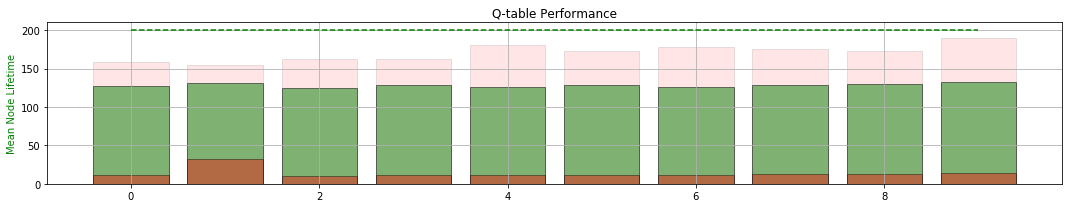

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  23898
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  134.65
Validating... MEAN TIME:  188.88
Validating... MEAN TIME:  158.07
Validating... MEAN TIME:  128.16
Validating... MEAN TIME:  161.09
TRAINING TIME:0:00:41.852055


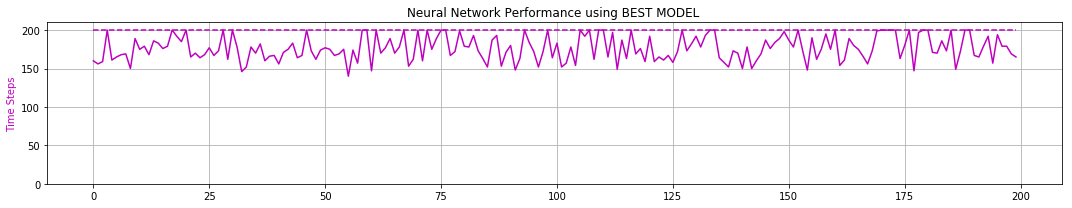

0 -max- [ 0.190  0.992  0.199  2.341  0.550]
0 -min- [-2.399 -3.282 -0.209 -1.799  0.375]

1 -max- [ 0.188  1.035  0.205  2.175  0.600]
1 -min- [-2.400 -3.160 -0.209 -1.831  0.401]

2 -max- [ 0.196  1.023  0.209  2.219  0.650]
2 -min- [-2.400 -3.137 -0.209 -1.772  0.451]

3 -max- [ 0.191  1.013  0.162  2.198  0.699]
3 -min- [-2.400 -3.177 -0.209 -1.664  0.501]

4 -max- [ 0.202  1.130  0.168  2.152  0.749]
4 -min- [-2.399 -3.293 -0.209 -1.935  0.551]

5 -max- [ 0.182  1.225  0.164  2.103  0.800]
5 -min- [-2.400 -3.138 -0.209 -2.044  0.600]

6 -max- [ 0.182  1.215  0.199  2.087  0.850]
6 -min- [-2.399 -3.132 -0.208 -1.830  0.651]

7 -max- [ 0.200  1.166  0.194  2.333  0.899]
7 -min- [-2.399 -3.182 -0.209 -1.726  0.700]

8 -max- [ 0.197  1.132  0.199  2.112  0.925]
8 -min- [-2.399 -3.155 -0.209 -1.707  0.750]

9 -max- [ 0.208  1.344  0.209  2.218  0.925]
9 -min- [-2.399 -3.266 -0.207 -1.943  0.800]



ITERATION # 25
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

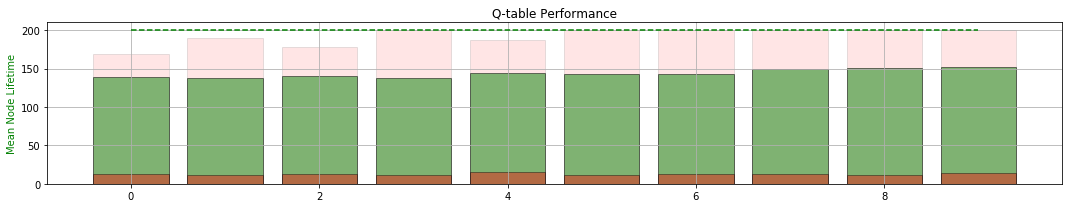

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  24888
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  151.345
Validating... MEAN TIME:  139.99
Validating... MEAN TIME:  167.945
Validating... MEAN TIME:  143.72
Validating... MEAN TIME:  178.38
TRAINING TIME:0:00:42.181517


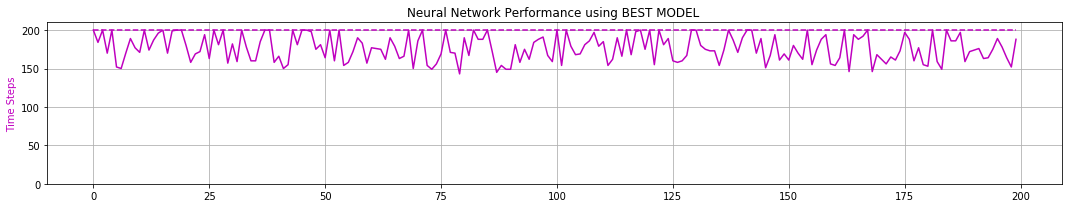

0 -max- [ 0.180  1.026  0.202  2.232  0.549]
0 -min- [-2.400 -3.145 -0.208 -1.803  0.375]

1 -max- [ 0.196  1.492  0.205  2.155  0.600]
1 -min- [-2.399 -3.163 -0.209 -1.903  0.400]

2 -max- [ 0.184  1.200  0.194  2.023  0.649]
2 -min- [-2.400 -3.178 -0.208 -1.813  0.450]

3 -max- [ 0.194  1.151  0.209  2.211  0.700]
3 -min- [-2.400 -3.173 -0.209 -1.736  0.500]

4 -max- [ 0.170  1.196  0.199  2.146  0.749]
4 -min- [-2.399 -3.122 -0.208 -1.911  0.550]

5 -max- [ 0.175  1.318  0.179  2.021  0.800]
5 -min- [-2.400 -3.141 -0.209 -1.885  0.600]

6 -max- [ 0.213  1.134  0.207  2.182  0.850]
6 -min- [-2.398 -3.166 -0.209 -1.693  0.651]

7 -max- [ 0.189  1.210  0.199  2.078  0.899]
7 -min- [-2.400 -3.161 -0.199 -1.662  0.700]

8 -max- [ 0.208  1.210  0.200  2.074  0.925]
8 -min- [-2.400 -3.171 -0.206 -1.785  0.750]

9 -max- [ 0.180  1.391  0.208  2.196  0.925]
9 -min- [-2.399 -3.143 -0.209 -1.953  0.801]



ITERATION # 26
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

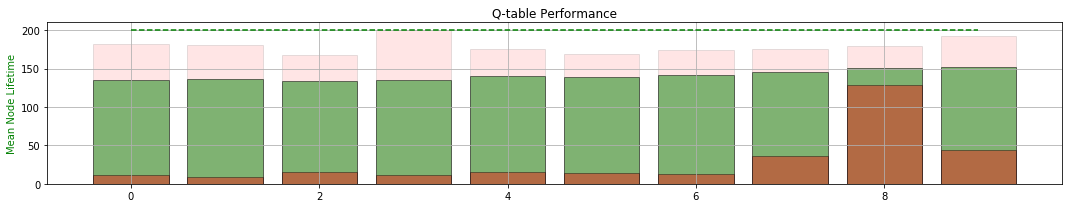

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  25887
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  169.63
Validating... MEAN TIME:  161.68
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  175.18
TRAINING TIME:0:00:47.171264


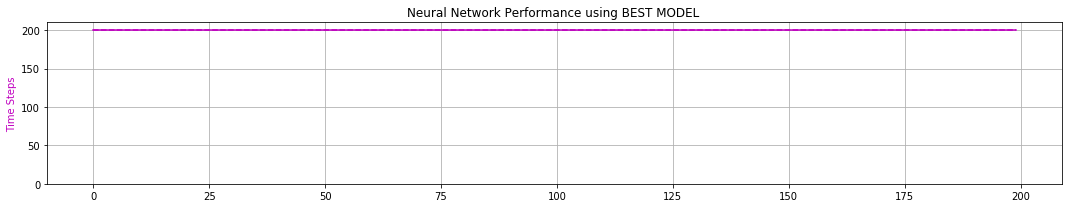

0 -max- [ 0.201  1.957  0.204  2.149  0.550]
0 -min- [-2.400 -3.308 -0.207 -2.541  0.375]

1 -max- [ 0.191  1.039  0.150  1.952  0.600]
1 -min- [-2.400 -3.180 -0.209 -1.884  0.400]

2 -max- [ 0.202  1.214  0.143  2.088  0.650]
2 -min- [-2.399 -3.182 -0.208 -1.890  0.450]

3 -max- [ 0.190  1.314  0.174  2.026  0.700]
3 -min- [-2.400 -3.168 -0.209 -1.890  0.500]

4 -max- [ 0.175  1.125  0.166  2.087  0.749]
4 -min- [-2.400 -3.161 -0.205 -1.847  0.550]

5 -max- [ 0.200  1.177  0.151  2.088  0.799]
5 -min- [-2.400 -3.187 -0.209 -1.881  0.600]

6 -max- [ 0.197  1.357  0.191  1.938  0.849]
6 -min- [-2.400 -3.172 -0.208 -2.001  0.650]

7 -max- [ 0.186  1.124  0.160  1.946  0.900]
7 -min- [-2.400 -3.144 -0.202 -1.946  0.701]

8 -max- [ 0.185  1.188  0.131  1.953  0.925]
8 -min- [-2.400 -3.162 -0.209 -1.674  0.750]

9 -max- [ 0.186  1.520  0.172  2.138  0.925]
9 -min- [-2.400 -3.169 -0.205 -2.103  0.800]



ITERATION # 27
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

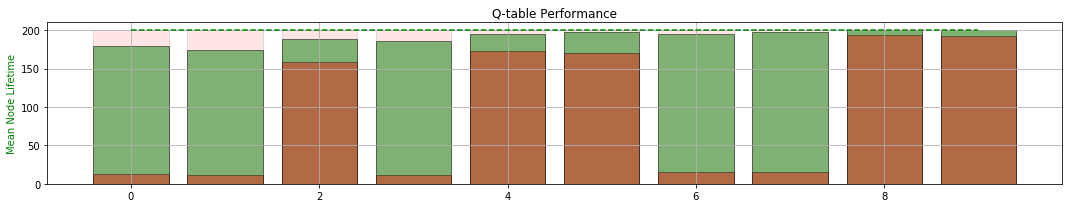

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  26302
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  134.645
Validating... MEAN TIME:  195.11
Validating... MEAN TIME:  156.445
Validating... MEAN TIME:  177.485
TRAINING TIME:0:00:45.336404


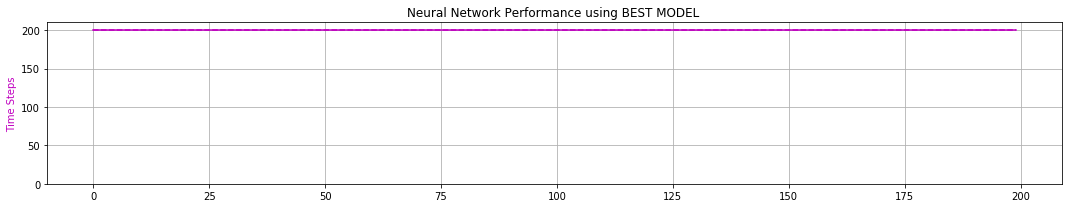

0 -max- [ 0.212  1.025  0.209  1.968  0.550]
0 -min- [-2.400 -2.437 -0.209 -1.658  0.375]

1 -max- [ 0.209  1.008  0.179  2.005  0.600]
1 -min- [-2.400 -2.548 -0.209 -1.693  0.400]

2 -max- [ 0.170  1.041  0.144  1.962  0.650]
2 -min- [-2.400 -2.609 -0.196 -1.834  0.450]

3 -max- [ 0.181  1.019  0.145  1.918  0.699]
3 -min- [-2.400 -2.394 -0.209 -1.660  0.501]

4 -max- [ 0.200  1.017  0.149  2.022  0.749]
4 -min- [-2.400 -2.402 -0.206 -1.658  0.550]

5 -max- [ 0.176  1.215  0.138  1.876  0.800]
5 -min- [-2.400 -2.235 -0.194 -1.821  0.600]

6 -max- [ 0.186  1.130  0.194  2.123  0.849]
6 -min- [-2.393 -2.417 -0.208 -1.953  0.650]

7 -max- [ 0.177  1.128  0.208  1.901  0.899]
7 -min- [-2.391 -2.240 -0.206 -1.802  0.701]

8 -max- [ 0.170  1.213  0.161  1.879  0.925]
8 -min- [-2.380 -2.224 -0.163 -1.668  0.750]

9 -max- [ 0.174  1.187  0.176  1.948  0.925]
9 -min- [-2.365 -2.260 -0.191 -1.684  0.802]



ITERATION # 28
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

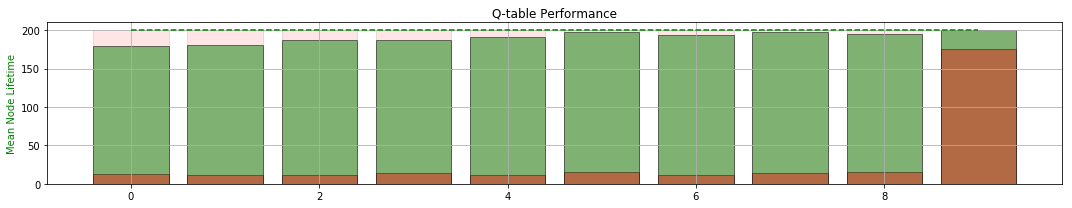

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  26593
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  198.5
Validating... MEAN TIME:  189.645
Validating... MEAN TIME:  161.75
Validating... MEAN TIME:  195.16
Validating... MEAN TIME:  200.0
TRAINING TIME:0:00:48.589665


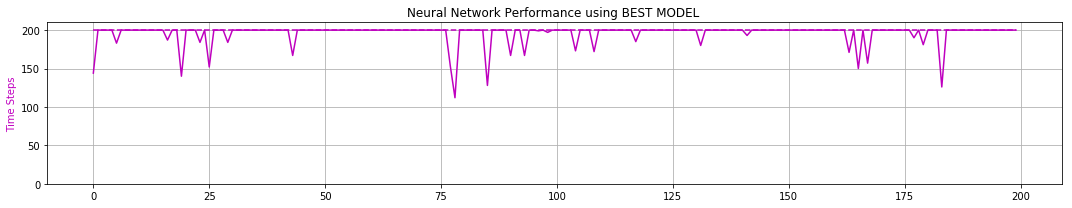

0 -max- [ 0.203  1.192  0.202  2.211  0.550]
0 -min- [-2.400 -2.591 -0.205 -1.912  0.375]

1 -max- [ 0.165  1.390  0.208  2.171  0.600]
1 -min- [-2.399 -2.408 -0.209 -1.964  0.401]

2 -max- [ 0.197  1.365  0.206  2.140  0.649]
2 -min- [-2.400 -2.440 -0.203 -1.736  0.450]

3 -max- [ 0.180  1.196  0.175  2.039  0.700]
3 -min- [-2.399 -2.259 -0.208 -1.837  0.501]

4 -max- [ 0.182  1.027  0.143  1.977  0.750]
4 -min- [-2.400 -2.253 -0.208 -1.664  0.550]

5 -max- [ 0.186  1.203  0.191  2.024  0.799]
5 -min- [-2.400 -2.168 -0.204 -1.721  0.601]

6 -max- [ 0.193  1.321  0.209  2.196  0.850]
6 -min- [-2.399 -2.196 -0.205 -1.869  0.650]

7 -max- [ 0.170  1.143  0.155  1.988  0.899]
7 -min- [-2.363 -2.053 -0.206 -1.910  0.700]

8 -max- [ 0.180  1.323  0.190  1.954  0.925]
8 -min- [-2.372 -2.435 -0.208 -1.885  0.750]

9 -max- [ 0.184  1.212  0.174  2.009  0.925]
9 -min- [-2.398 -2.134 -0.199 -1.757  0.801]



ITERATION # 29
MEAN TABULAR EPSILON =  0.98
TABULAR LR      =  0.1
SMALLEST TIMESTEP in 

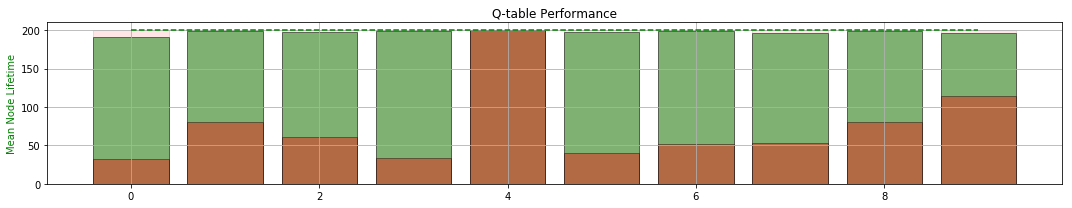

GOOD MEMORY COUNTER:  100000
BAD MEMORY COUNTER:  26624
Training Neural Network for 7000 iterations @ LR =  0.001
16 TERMINAL EXPERIENCES IN A BATCH SIZE OF 32
Validating... MEAN TIME:  200.0
Validating... MEAN TIME:  72.04
Validating... MEAN TIME:  53.29
Validating... MEAN TIME:  132.695
Validating... MEAN TIME:  163.54
TRAINING TIME:0:00:35.770783


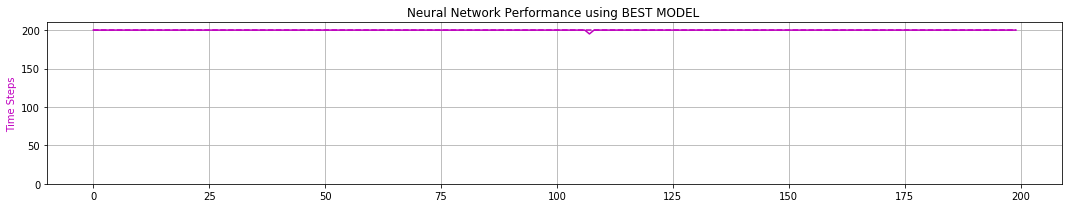

0 -max- [ 0.196  1.745  0.207  1.937  0.550]
0 -min- [-2.065 -1.911 -0.209 -2.240  0.375]

1 -max- [ 0.154  1.727  0.170  2.079  0.599]
1 -min- [-1.969 -1.908 -0.209 -2.478  0.401]

2 -max- [ 0.152  1.746  0.166  1.962  0.649]
2 -min- [-1.797 -1.871 -0.193 -2.462  0.450]

3 -max- [ 0.152  1.207  0.163  2.177  0.699]
3 -min- [-1.786 -2.123 -0.203 -1.924  0.500]

4 -max- [ 0.186  1.352  0.159  1.904  0.749]
4 -min- [-1.035 -1.857 -0.159 -1.954  0.551]

5 -max- [ 0.183  1.791  0.171  1.946  0.799]
5 -min- [-0.942 -1.860 -0.204 -2.464  0.600]

6 -max- [ 0.169  1.774  0.151  1.899  0.849]
6 -min- [-0.696 -1.574 -0.190 -2.362  0.651]

7 -max- [ 0.560  1.952  0.189  1.959  0.899]
7 -min- [-0.529 -1.697 -0.208 -2.554  0.700]

8 -max- [ 0.940  2.128  0.192  2.231  0.925]
8 -min- [-0.423 -1.532 -0.199 -2.378  0.751]

9 -max- [ 1.119  2.152  0.171  2.218  0.925]
9 -min- [-0.155 -1.532 -0.208 -2.446  0.800]



In [19]:
while iteration < MAX_NO_OF_ITERATIONS:
    if iteration < 3:
        node_EPSILON   = (iteration+1) * 0.2
    else:
        node_EPSILON   = T_EPSILON
    
    print("\n")
    print("ITERATION #", iteration)
    print("MEAN TABULAR EPSILON = ", node_EPSILON)
    print("TABULAR LR      = ", T_LR)

    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)

    print("SMALLEST TIMESTEP in ITERATION {:d}: {:d}".format(iteration, node_time_rec.min().astype(int)))
    print("REAL TIME TO GENERATE {:d} EXPERIENCES:{}".format(EXP_GEN, (datetime.now()-tic)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_min_time.min() > 195:
        print("Problem SOLVED in iteration#", iteration)
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
    bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


    dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
    dqn.good_memory_counter += good_mem.shape[0]

    dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
    dqn.bad_memory_counter += bad_mem.shape[0]

    dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
    dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS

    print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
    print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    if iteration < 3:
        NN_LR = 1e-4
    else:
        NN_LR = 1e-3
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    print(int(BATCH_SIZE*TERMINAL_BIAS),"TERMINAL EXPERIENCES IN A BATCH SIZE OF",BATCH_SIZE)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("Validating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)

                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)

                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)
            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
    ##################################################################
    start = timeit.default_timer()
    for node_id in range(NO_OF_NODES):
#         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
#         ###############################################
        [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
         C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
#         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
        node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
                                    C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
#         # CREATE STATE COMBINATIONS
#         ###############################################

#         node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN ],
#                                             [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX ],
#                                             [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################

#         # GET Q-VALUES 
#         %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#         # SAVE QFILE
#         node_QFILE = './Q_NPY/' + RNDM_STRING + str(node_id) + 'QFILE' + ".npy"
#         np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
#     print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()
    

In [20]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  5085.0
Total Serial Timesteps   :  3808041.0
Speed-up                 :  748.88


In [21]:
pool.close()
pool.join()